# 21.05.21.

In [1]:
from mcbj import *
from pca_and_ml import *
from noise import *
import filter_traces

from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
import re
import pandas as pd
import plots

date = "21_05_21"
sample_rate = 50_000
# home_folder = Path(f"D:/BJ_Data/{date}")
home_folder = Path(f'//DATACENTER/BreakJunction_group/BJ_Data/{date}')
results_folder = home_folder.joinpath('results')

## Histogram of traces after evaporation with hold measurement

In [2]:
after_evap_w_hold = np.hstack((np.arange(1632, 5733, 1),
                               np.arange(7002, 12648, 1),
                               np.arange(14401, 19575, 1),
                               np.arange(20046, 23317, 1),
                               np.arange(25201, 27744, 1),
                               np.arange(32001, 36866, 1),
                               np.arange(38553, 43222, 1)
                               ))

In [3]:
after_evap_w_hold.shape

(30269,)

In [4]:
hist_BPY_hold = Histogram(folder=home_folder,
                          load_from=home_folder.joinpath('results/hist_BPY_hold.h5'),
                          traces=after_evap_w_hold,
                          conductance_range=(1e-5, 10),
                          conductance_log_scale=True,
                          conductance_bins_num=100,
                          conductance_bins_mode='total')

In [5]:
# hist_BPY_hold.calc_stats(align_at=0.5,
#                          range_pull=(-1, 1),
#                          range_push=(-0.5, 1.5))

(0.0, 3000.0)

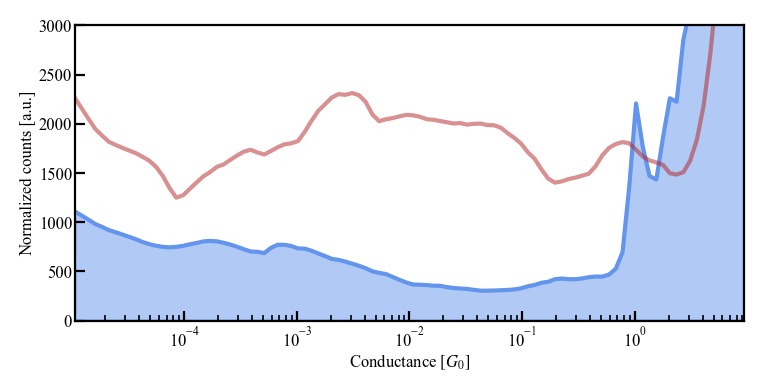

In [6]:
ax_hist_BPY_hold = hist_BPY_hold.plot_hist_1d(dpi=200)
ax_hist_BPY_hold.set_ylim(0, 3000)

In [7]:
# pull_not_break, push_not_break = filter_traces.filter_hold(folder=home_folder, filter_condition=filter_traces.does_not_break_array, traces=after_evap_w_hold)

In [8]:
# np.save(home_folder.joinpath('results/pull_not_break_hold.npy'), pull_not_break)
# np.save(home_folder.joinpath('results/push_not_break_hold.npy'), push_not_break)

In [9]:
pull_not_break = np.load(home_folder.joinpath('results/pull_not_break_hold.npy'))
push_not_break = np.load(home_folder.joinpath('results/push_not_break_hold.npy'))

In [10]:
print(pull_not_break.shape[0])
print(push_not_break.shape[0])

27431
29456


In [11]:
which_trace = np.random.choice(pull_not_break)
print(which_trace)

8298


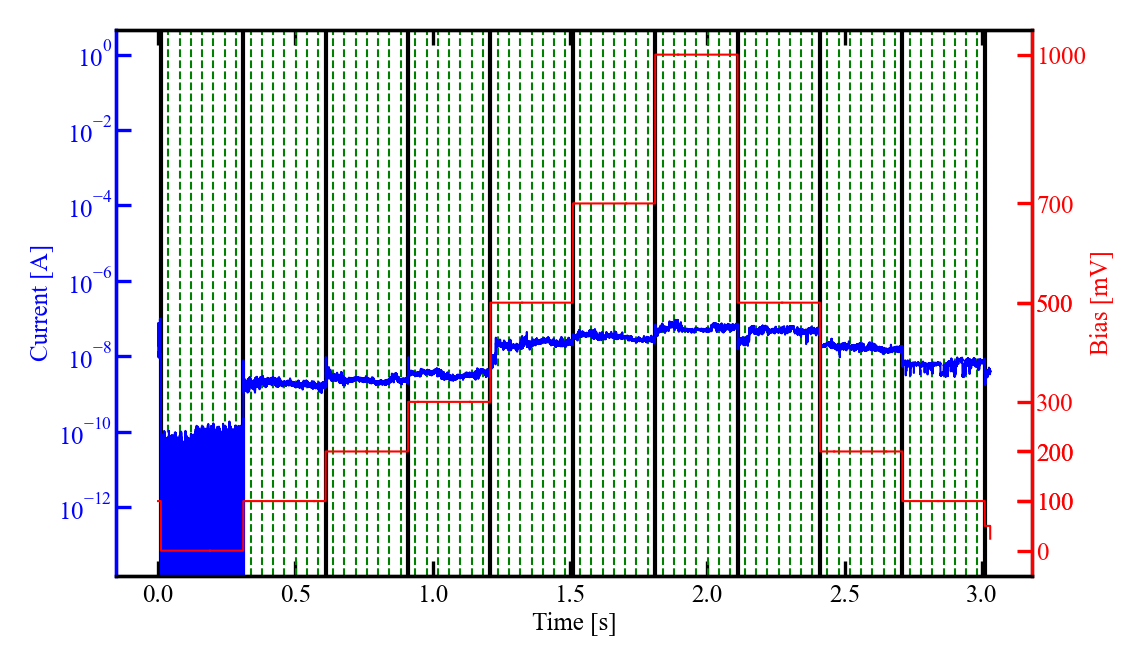

In [12]:
hold_trace = HoldTrace(which_trace, load_from=home_folder, r_serial_ohm=99_000)
hold_trace.analyse_hold_trace(num_of_fft=6, freq_range=(1000, 10000))
ax, par = hold_trace.plot_hold_traces(conductance=False, plot_step_ranges=True, plot_psd_intervals=True, dpi=300)

# ax.set_ylim(1e-7, 1e-6)
# ax.set_xlim(1.5, 2.3)
# ax.axhline(1e-3)
# ax.axhline(2e-3)

<AxesSubplot:xlabel='Frequency [Hz]', ylabel='$S_{I}\\;[\\mathrm{A}^2/\\mathrm{Hz}]$'>

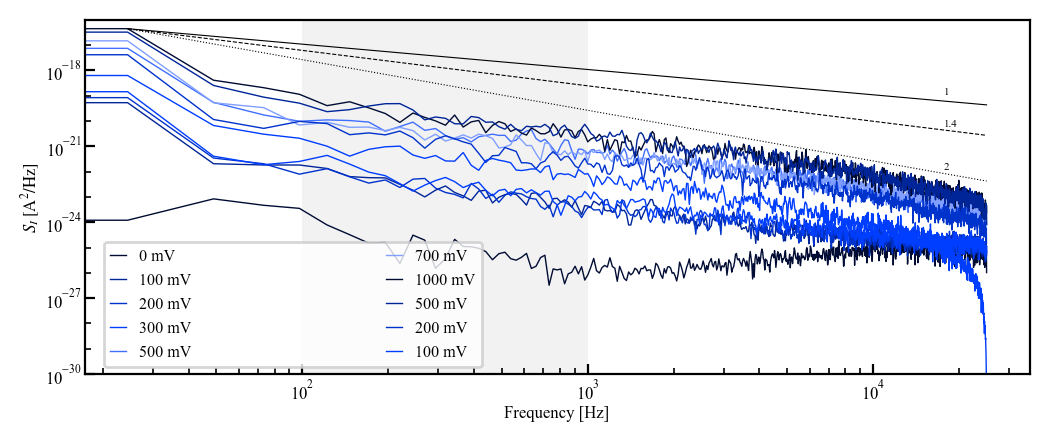

In [13]:
hold_trace.plot_psds(dpi=200)

In [14]:
hold_trace.bias_steps

array([-1.3085937e-05,  9.9993020e-02,  1.9999912e-01,  3.0000523e-01,
        4.9998692e-01,  6.9999909e-01,  9.9998689e-01,  4.9998692e-01,
        1.9999912e-01,  9.9993020e-02], dtype=float32)

In [15]:
hold_trace.__dict__

{'bias_offset': 0,
 'R_ser': 99000,
 'sample_rate': 50000,
 'gain': 10000000.0,
 'r0': 12900,
 'g0': 7.751937984496124e-05,
 'time_axis_pull': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 3.02992e+00,
        3.02994e+00, 3.02996e+00]),
 'time_axis_push': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 3.02990e+00,
        3.02992e+00, 3.02994e+00]),
 'hold_current_pull': array([2.6687502e-08, 2.6892065e-08, 3.1270957e-08, ..., 3.9229140e-09,
        3.9520964e-09, 3.8939225e-09], dtype=float32),
 'hold_bias_pull': array([0.09999302, 0.09999302, 0.09999302, ..., 0.05000522, 0.05000522,
        0.02420261], dtype=float32),
 'hold_conductance_pull': array([0.00353637, 0.00356422, 0.00416313, ..., 0.00101993, 0.00102757,
        0.00210905]),
 'hold_current_push': array([6.1465011e-09, 6.5129027e-09, 6.3698518e-09, ..., 2.5208222e-09,
        2.7508484e-09, 2.6549087e-09], dtype=float32),
 'hold_bias_push': array([0.09999302, 0.09999302, 0.09999302, ..., 0.05000522, 0.05000522,
 

In [16]:
hold_trace.bias_steps.shape

(10,)

In [18]:
from utils import MeasurementOverflow

In [21]:
biases_all = []
gammas_all = []
avg_conds_all = []
eval_traces = []
overflow_traces = []
nan_traces = []

for trace in tqdm(pull_not_break):
    try:
        hold_trace = HoldTrace(trace, load_from=home_folder, r_serial_ohm=99_000)
        hold_trace.analyse_hold_trace(num_of_fft=6, freq_range=(1000, 10000))
        eval_traces.append(trace)
    except MeasurementOverflow:
        overflow_traces.append(trace)
        continue
    except ValueError:
        nan_traces.append(trace)
        continue

    biases = hold_trace.bias_steps[1:]
    gammas = hold_trace.psd_fitparams_pull[1:, 0]
    avg_conds = hold_trace.avg_cond_on_step_pull[1:]
    
    biases_all.append(biases)
    gammas_all.append(gammas)
    avg_conds_all.append(avg_conds)
    
eval_traces = np.array(eval_traces)
overflow_traces = np.array(overflow_traces)
nan_traces = np.array(nan_traces)

  0%|          | 0/27431 [00:00<?, ?it/s]

In [27]:
biases_all = np.array(biases_all)
gammas_all = np.array(gammas_all)
avg_conds_all = np.array(avg_conds_all)

In [41]:
all(biases_all[0] == np.unique(biases_all, axis=0).flatten())

True

In [49]:
gammas_all.shape

(26347, 9)

In [79]:
biases_all[0]

array([0.09999302, 0.19999912, 0.30000523, 0.49998692, 0.6999991 ,
       0.9999869 , 0.49998692, 0.19999912, 0.09999302], dtype=float32)

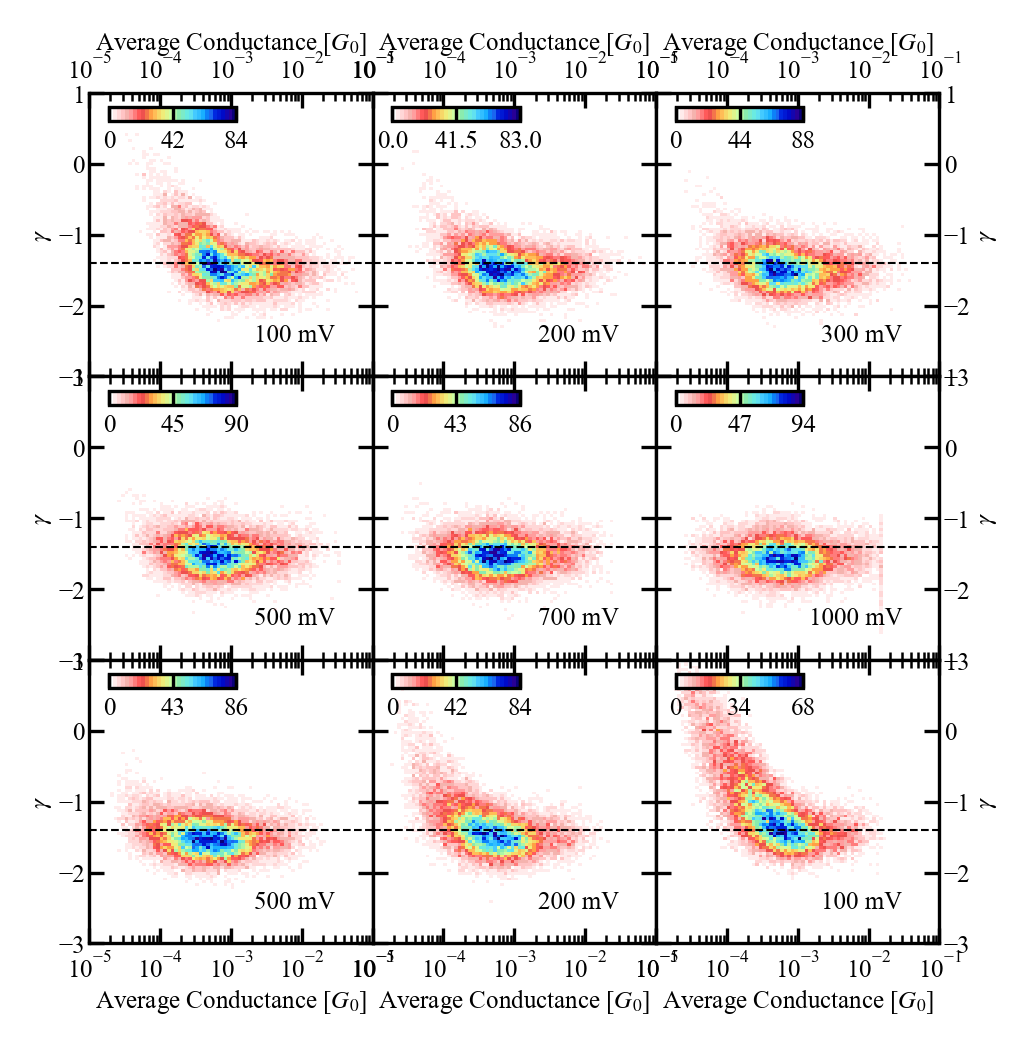

In [103]:
fig = plt.figure(figsize=utils.cm2inch(9, 9), dpi=300)
gs = gridspec.GridSpec(nrows=3, ncols=3,
                       figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0, hspace=0)

axs = []
gamma_hists=[]

for i in range(3):
    for j in range(3):
        if j > 0:
            axs.append(fig.add_subplot(gs[i, j]))
        else:
            axs.append(fig.add_subplot(gs[i, j]))
            
        axs[i*3+j].set_xscale('log')
        axs[i*3+j].set_xlim(1e-5, 0.1)
        axs[i*3+j].set_ylim(-3, 1)
        axs[i*3+j].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        axs[i*3+j].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        
        if i==0:
            axs[i*3+j].xaxis.tick_top()
            axs[i*3+j].xaxis.set_label_position('top')
            axs[i*3+j].set_xlabel(r'Average Conductance [$G_{0}$]')
        if i==2:
            axs[i*3+j].set_xlabel(r'Average Conductance [$G_{0}$]')
        if i==1:
            axs[i*3+j].set_xticklabels([])
        if j==2:
            axs[i*3+j].yaxis.tick_right()
            axs[i*3+j].yaxis.set_label_position('right')
            axs[i*3+j].set_ylabel(r'$\gamma$')
        if j==0:
            axs[i*3+j].set_ylabel(r'$\gamma$')
            
        axs[i*3+j].yaxis.set_ticks_position('both')
        axs[i*3+j].xaxis.set_ticks_position('both')
        
        x_mesh, y_mesh, gamma_hist = utils.calc_hist_2d_single(x=avg_conds_all[:, i*3+j], y=-1*gammas_all[:, i*3+j],
                                                               xrange=(1e-5, 1e-1), log_scale_x=True,
                                                               yrange=(-3, 1), log_scale_y=False,
                                                               num_bins=(20, 100),
                                                               bin_mode_x='decade')
        
        gamma_hists.append(gamma_hist)
        im = axs[i*3+j].pcolormesh(x_mesh, y_mesh, gamma_hists[-1], cmap=utils.cmap_geo32)
        cbaxes = axs[i*3+j].inset_axes([0.07, 0.9, 0.45, 0.05])
        plt.colorbar(im, cax=cbaxes, ticks=np.linspace(0, max(gamma_hists[-1].flatten()), 3), orientation='horizontal')
        # axs[i*3+j].scatter(avg_conds_all[:, i*3+j], -1*gammas_all[:, i*3+j], s=0.1, alpha=0.3, edgecolor='None')
        axs[i*3+j].axhline(-1.4, lw=0.5, ls='--', c='k')
        
        axs[i*3+j].text(0.03, -2.5, f'{round(biases_all[0][i*3+j]*1000)} mV', ha='right', fontsize=6)

    axs[i*3+1].set_yticklabels([])
        
plt.savefig(home_folder.joinpath('results/slope_2d_hists_pull.png'), bbox_inches='tight')

In [92]:
biases_all_push = []
gammas_all_push = []
avg_conds_all_push = []
eval_traces = []
overflow_traces = []
nan_traces = []

for trace in tqdm(push_not_break):
    try:
        hold_trace = HoldTrace(trace, load_from=home_folder, r_serial_ohm=99_000)
        hold_trace.analyse_hold_trace(num_of_fft=6, freq_range=(1000, 10000))
        eval_traces.append(trace)
    except MeasurementOverflow:
        overflow_traces.append(trace)
        continue
    except ValueError:
        nan_traces.append(trace)
        continue

    biases = hold_trace.bias_steps[1:]
    gammas = hold_trace.psd_fitparams_push[1:, 0]
    avg_conds = hold_trace.avg_cond_on_step_push[1:]
    
    biases_all_push.append(biases)
    gammas_all_push.append(gammas)
    avg_conds_all_push.append(avg_conds)
    
eval_traces = np.array(eval_traces)
overflow_traces = np.array(overflow_traces)
nan_traces = np.array(nan_traces)

  0%|          | 0/29456 [00:00<?, ?it/s]

In [93]:
biases_all_push = np.array(biases_all_push)
gammas_all_push = np.array(gammas_all_push)
avg_conds_all_push = np.array(avg_conds_all_push)

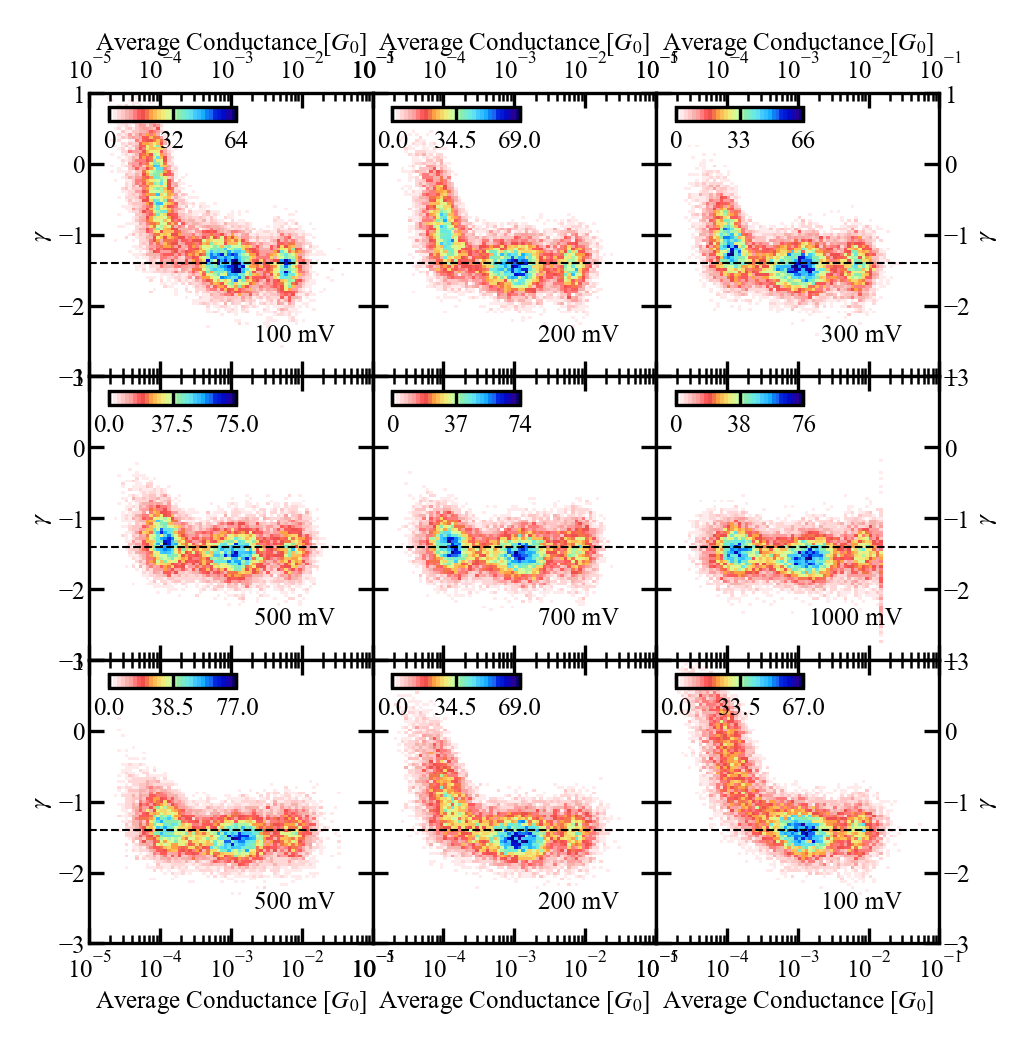

In [104]:
fig = plt.figure(figsize=utils.cm2inch(9, 9), dpi=300)
gs = gridspec.GridSpec(nrows=3, ncols=3,
                       figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0, hspace=0)

axs = []
gamma_hists=[]

for i in range(3):
    for j in range(3):
        if j > 0:
            axs.append(fig.add_subplot(gs[i, j]))
        else:
            axs.append(fig.add_subplot(gs[i, j]))
            
        axs[i*3+j].set_xscale('log')
        axs[i*3+j].set_xlim(1e-5, 0.1)
        axs[i*3+j].set_ylim(-3, 1)
        axs[i*3+j].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        axs[i*3+j].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        
        if i==0:
            axs[i*3+j].xaxis.tick_top()
            axs[i*3+j].xaxis.set_label_position('top')
            axs[i*3+j].set_xlabel(r'Average Conductance [$G_{0}$]')
        if i==2:
            axs[i*3+j].set_xlabel(r'Average Conductance [$G_{0}$]')
        if i==1:
            axs[i*3+j].set_xticklabels([])
        if j==2:
            axs[i*3+j].yaxis.tick_right()
            axs[i*3+j].yaxis.set_label_position('right')
            axs[i*3+j].set_ylabel(r'$\gamma$')
        if j==0:
            axs[i*3+j].set_ylabel(r'$\gamma$')
            
        axs[i*3+j].yaxis.set_ticks_position('both')
        axs[i*3+j].xaxis.set_ticks_position('both')
        
        x_mesh, y_mesh, gamma_hist = utils.calc_hist_2d_single(x=avg_conds_all_push[:, i*3+j], y=-1*gammas_all_push[:, i*3+j],
                                                               xrange=(1e-5, 1e-1), log_scale_x=True,
                                                               yrange=(-3, 1), log_scale_y=False,
                                                               num_bins=(20, 100),
                                                               bin_mode_x='decade')
        
        gamma_hists.append(gamma_hist)
        im = axs[i*3+j].pcolormesh(x_mesh, y_mesh, gamma_hists[-1], cmap=utils.cmap_geo32)
        cbaxes = axs[i*3+j].inset_axes([0.07, 0.9, 0.45, 0.05])
        plt.colorbar(im, cax=cbaxes, ticks=np.linspace(0, max(gamma_hists[-1].flatten()), 3), orientation='horizontal')
        # axs[i*3+j].scatter(avg_conds_all_push[:, i*3+j], -1*gammas_all_push[:, i*3+j], s=0.1, alpha=0.3, edgecolor='None')
        axs[i*3+j].axhline(-1.4, lw=0.5, ls='--', c='k')
        
        axs[i*3+j].text(0.03, -2.5, f'{round(biases_all_push[0][i*3+j]*1000)} mV', ha='right', fontsize=6)
    
    axs[i*3+1].set_yticklabels([])
        
plt.savefig(home_folder.joinpath('results/slope_2d_hists_push.png'), bbox_inches='tight')

In [105]:
hold_trace.bias_steps*1000

array([-1.3085937e-02,  9.9993019e+01,  1.9999913e+02,  3.0000522e+02,
        4.9998691e+02,  6.9999908e+02,  9.9998688e+02,  4.9998691e+02,
        1.9999913e+02,  9.9993019e+01], dtype=float32)

In [106]:
hold_trace.__dict__

{'bias_offset': 0,
 'R_ser': 99000,
 'sample_rate': 50000,
 'gain': 10000000.0,
 'r0': 12900,
 'g0': 7.751937984496124e-05,
 'time_axis_pull': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 3.02996e+00,
        3.02998e+00, 3.03000e+00]),
 'time_axis_push': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 3.02994e+00,
        3.02996e+00, 3.02998e+00]),
 'hold_current_pull': array([3.1244980e-09, 3.2925354e-09, 3.1967866e-09, ..., 3.4959186e-10,
        3.4139025e-10, 2.8550493e-10], dtype=float32),
 'hold_bias_pull': array([0.09999302, 0.09999302, 0.09999302, ..., 0.05000522, 0.05000522,
        0.02420261], dtype=float32),
 'hold_conductance_pull': array([4.04339180e-04, 4.26155903e-04, 4.13723723e-04, ...,
        9.02477422e-05, 8.81290522e-05, 1.52352133e-04]),
 'hold_current_push': array([ 6.4570771e-10,  6.0059890e-10,  6.5133438e-10, ...,
         1.9620533e-11, -2.2055035e-11,  5.0805683e-11], dtype=float32),
 'hold_bias_push': array([0.09999302, 0.09999302, 0.09999302, 